<a href="https://colab.research.google.com/github/alepenaa94/TP1_Real_or_Not/blob/master/TP1_Real_or_Not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

plt.style.use('default')
plt.rcParams['figure.figsize'] = (6, 10)
sns.set(style="darkgrid")
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':"1GKPasgRV2WrBkN2AaeKtvUI01BqvE7MA"})
downloaded.GetContentFile('train.csv')

downloaded = drive.CreateFile({'id':"1adIQXiZazufU25CVBYC3K_yTUl9YNpTg"})
downloaded.GetContentFile('test.csv')

downloaded = drive.CreateFile({'id':"1TmlwXmYSN4Yed0K1Gwtp8SLOYe_GlxuN"})
downloaded.GetContentFile('sample_submissions.csv')


In [0]:
train_df = pd.read_csv('train.csv', encoding='latin-1')

In [5]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Tratamiento de datos

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Podemos observar que las columnas <b><i>"keyword"</i></b> y <b><i>"location"</i></b> poseen algunos valores nulos, vamos a ver si podemos realizar algun tratamiento en particular.
<br>
A su vez se podria tratar target como tipo int32 o mejor categorico o booleano, para esto se podria hacer:<br>
>train_df['target] = train_df['target].astype('category')

In [7]:
train_df['keyword'].describe()

count           7552
unique           221
top       fatalities
freq              45
Name: keyword, dtype: object

In [0]:
train_df['keyword'].fillna(value='',inplace=True)

Posiblemente luego analicemos los textos y veamos la posibilidad de completar estos keyword vacios con algun valor mas significativo

In [9]:
train_df['location'].describe()

count     5080
unique    3341
top        USA
freq       104
Name: location, dtype: object

In [10]:
train_df['location'].sample(30)

766                                     NaN
1644                                    NaN
1951                      Des Moines, Iowa 
3867                                    NaN
6861                    The Jewfnited State
7180                          BROOKLYN, NYC
7352                                    NaN
5997    #Gladiator ÂÃÂ¢860ÂÃÂ¢757ÂÃÂ¢
6073                          San Diego, CA
6747                                    NaN
7611                                    NaN
3034                               oklahoma
452                                     NaN
2337                                    NaN
1709                          San Francisco
3476                    Chicago Heights, IL
169                                     nyc
5168                              Jump City
4507                                    NaN
3992                                 canada
4498                               New York
1041                                    NaN
7397                            

Por ahora dejamos en blanco estos datos, se observa que la ubicacion ingresada no es siempre algo coherente.

## Primeros analisis

In [0]:
train_df['word_count'] = train_df['text'].str.count(' ') + 1
train_df['not_target'] = 0
train_df.loc[train_df['target']==0,'not_target'] = 1

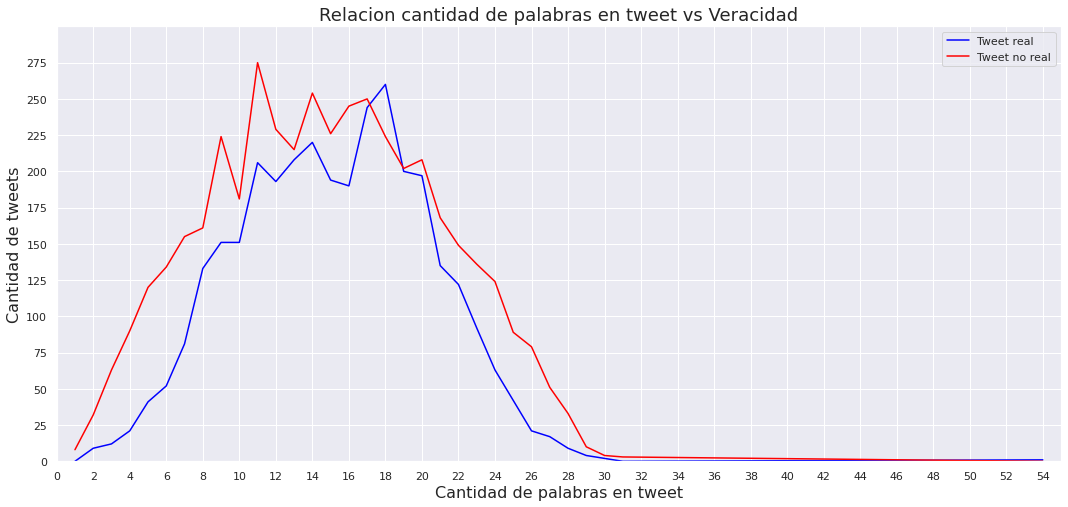

In [12]:
df = train_df.groupby('word_count').agg({'target':'sum','not_target':'sum'}).reset_index()

plt.figure(figsize=(18,8))
ax = sns.lineplot(x='word_count',y='target',data=df,color="blue", label='Tweet real')
ax = sns.lineplot(x='word_count',y='not_target',data=df,color="red", label='Tweet no real')
ax.set_ylim(0,300)
ax.set_yticks(range(0,300,25))
ax.set_xlim(0,55)
ax.set_xticks(range(0,55,2))

ax.set_title('Relacion cantidad de palabras en tweet vs Veracidad', fontsize=18)
ax.set_xlabel('Cantidad de palabras en tweet',fontsize=16)
ax.set_ylabel('Cantidad de tweets', fontsize=16);